In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [3]:
N_Agents = 1
in_dim = 1
batch_size = 128
num_samples = 1000 ## samples linspace of target and objective funciton
n_samples = 2048 ## samples per epoch TODO better naming
timesteps = 30
lam = 0.5
control_energy_reg = 1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = -1e-2 ### softness on constraint (will penalize when this much outside of rect)


In [4]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [5]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return torch.tensor(np.where(((x > 0) & (x < 1)), 1., 0), dtype = torch.float32)
    #return torch.tensor(np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0))

In [56]:
import Ergodic_Loss_timedomain
import Recursive_KAN
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, num_samples = num_samples)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', thres = thres)
model.init_hidden(batch_size = batch_size)

In [57]:
exploding_threshold = 1e5  # Example threshold for exploding gradients
vanishing_threshold = 1e-5  # Example threshold for vanishing gradients
def print_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()  # Gradient norm (magnitude)
            if grad_norm > exploding_threshold:
                print(f"  *** Exploding gradient detected for {name} ***")
            elif grad_norm < vanishing_threshold:
                print(f"  *** Vanishing gradient detected for {name} ***")


per iter: 0.2756030559539795 total time: 1322.8946685791016
Epoch [1/300], Loss: 2.035784
Epoch [2/300], Loss: 1.874990
Epoch [3/300], Loss: 1.889409
Epoch [4/300], Loss: 1.894188
Epoch [5/300], Loss: 1.787630
Epoch [6/300], Loss: 1.625572
Epoch [7/300], Loss: 1.415080
Epoch [8/300], Loss: 1.342098
Epoch [9/300], Loss: 1.068472
Epoch [10/300], Loss: 0.767728
Epoch [11/300], Loss: 0.342046
Epoch [12/300], Loss: 0.123915
Epoch [13/300], Loss: 0.215804
Epoch [14/300], Loss: 0.303833
Epoch [15/300], Loss: 0.122622
Epoch [16/300], Loss: 0.118364
Epoch [17/300], Loss: 0.110568
Epoch [18/300], Loss: 0.093368
Epoch [19/300], Loss: 0.067030
Epoch [20/300], Loss: 0.047668
Epoch [21/300], Loss: 0.045373
Epoch [22/300], Loss: 0.041266
Epoch [23/300], Loss: 0.038367
Epoch [24/300], Loss: 0.036202
Epoch [25/300], Loss: 0.035035
Epoch [26/300], Loss: 0.031925
Epoch [27/300], Loss: 0.032014
Epoch [28/300], Loss: 0.031224
Epoch [29/300], Loss: 0.028715
Epoch [30/300], Loss: 0.027919
Epoch [31/300], Los

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [300/300], Loss: 0.000012


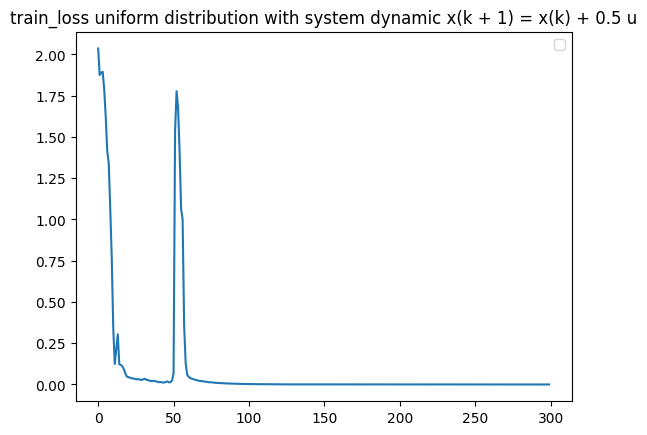

Training Complete!


In [58]:
import time
epochs = 300  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print_grad(model)
        if show:
            show = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

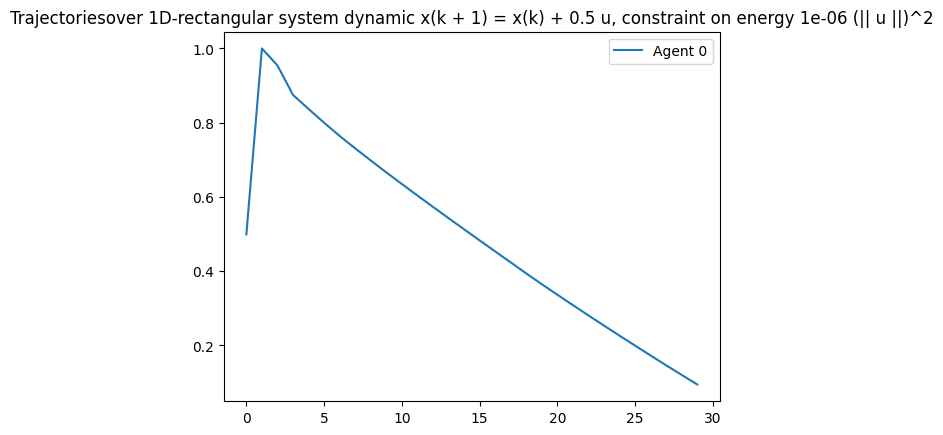

In [55]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



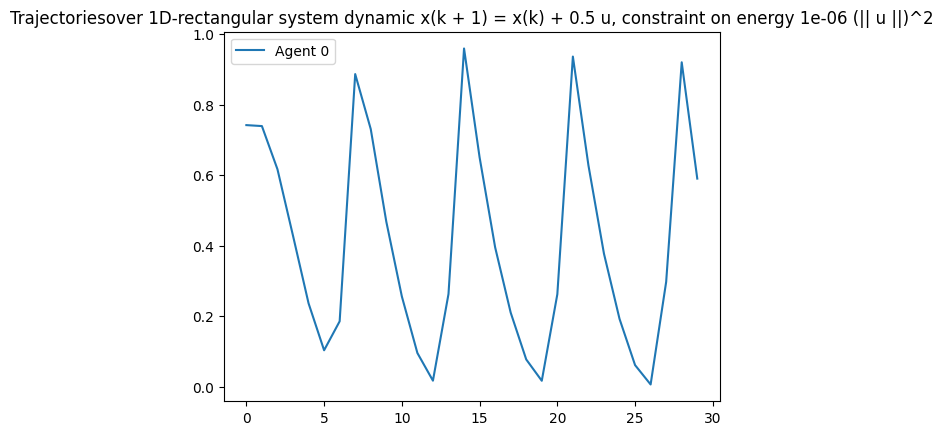

model tensor([7.4752e-02, 8.8036e-02, 1.0309e-01, 1.1997e-01, 1.3871e-01, 1.5928e-01,
        1.8164e-01, 2.0570e-01, 2.3138e-01, 2.5857e-01, 2.8716e-01, 3.1706e-01,
        3.4813e-01, 3.8021e-01, 4.1309e-01, 4.4648e-01, 4.8003e-01, 5.1333e-01,
        5.4593e-01, 5.7737e-01, 6.0723e-01, 6.3515e-01, 6.6086e-01, 6.8420e-01,
        7.0509e-01, 7.2356e-01, 7.3971e-01, 7.5369e-01, 7.6569e-01, 7.7590e-01,
        7.8455e-01, 7.9182e-01, 7.9791e-01, 8.0300e-01, 8.0722e-01, 8.1073e-01,
        8.1363e-01, 8.1602e-01, 8.1800e-01, 8.1962e-01, 8.2096e-01, 8.2206e-01,
        8.2296e-01, 8.2370e-01, 8.2431e-01, 8.2481e-01, 8.2522e-01, 8.2555e-01,
        8.2583e-01, 8.2606e-01, 8.2624e-01, 8.2639e-01, 8.2652e-01, 8.2662e-01,
        8.2671e-01, 8.2678e-01, 8.2684e-01, 8.2689e-01, 8.2693e-01, 8.2697e-01,
        8.2700e-01, 8.2703e-01, 8.2706e-01, 8.2709e-01, 8.2712e-01, 8.2715e-01,
        8.2719e-01, 8.2723e-01, 8.2727e-01, 8.2733e-01, 8.2739e-01, 8.2747e-01,
        8.2756e-01, 8.2768e-01, 8.

tensor(1.0993, grad_fn=<AddBackward0>)

In [27]:
import Ergodic_Loss_timedomain
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 1, num_samples = 1000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion.verbose = True
criterion(x = outs, u = control)

In [ ]:
indices = torch.nonzero(criterion.function_values[0] > 0)
print(indices)
criterion.samples[indices]

In [ ]:
criterion(x = outs, u = control)